# Problem Statement

In the globalized world, effective cross-lingual communication is crucial for fostering international collaboration, cultural exchange, and business growth. However, the language barrier remains a significant obstacle. In this presentation we want to address this challenge by introducing our research on developing models for English-to-Italian translation using NLP techniques.

The key problems to tackle include ensuring translation accuracy by preserving context and meaning and maintain translation quality. We will evaluate how each model addresses this concern and considering their ability to handle translation quality.

By comparing Transformer, MarianMT and LSTM models comprehensively, we seek to provide insights on their performance and evaluate some weaknesses of the models. In a word, our research aims to contribute to improved language learning.


We aimed to produce a language translation model using the Marian language model. We changed the training parameters to produce an accurate english to italian language translation model.

# MarianMT

Most of the imports we need are loaded

In [1]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np
import torch
from torch.optim import AdamW, lr_scheduler

/home/bluetgamer18/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking if CUDA the device supports CUDA. If it does, hugging face will automatically use CUDA.

In [2]:
# Check if CUDA is available
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")

Is CUDA supported by this system? True


Change Checkpoint to use a different model. Hugging face has many different seq2seq models to use.

In [2]:
# Change checkpoint to specify what model you want
source_lang = "en"

target_lang = "it"
prefix = "translate English to Italian: "
checkpoint = "Helsinki-NLP/opus-mt-en-it"

print("Checkpoint is " + checkpoint)

Checkpoint is Helsinki-NLP/opus-mt-en-it


## DataSet Preparation

Using the Dataset library, we downloaded the dataset. We used load_dataset to download the opus book dataset from hugging face. We also specified to get the english to italian dataset. The dataset can be found here: https://huggingface.co/datasets/opus_books/viewer/en-it/train

In [3]:
# loads dataset
# can change language here
books = load_dataset("opus_books", "en-it")

Found cached dataset opus_books (/home/bluetgamer18/.cache/huggingface/datasets/opus_books/en-it/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.12it/s]


As we can see, the dataset contains 32332 lines of english to italian translations.

In [5]:
books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 32332
    })
})

This shows what the dataset looks like.

In [6]:
books['train'][10]

{'id': '10',
 'translation': {'en': '"Jane, I don\'t like cavillers or questioners; besides, there is something truly forbidding in a child taking up her elders in that manner.',
  'it': '— Jane, non mi piace di essere interrogata. Sta male, del resto, che una bimba tratti così i suoi superiori.'}}

We first split the dataset with 80% for training and 20% for test and validation. We then split the test and validiation dataset in half so that 10% of the dataset if for testing and 10% of the dataset is for validation.

In [4]:
# Splitting the data

# 80% train, 20% test + validation
books = books["train"].train_test_split(test_size=0.2)
# Split the 20% test + valid in half test, half valid
# Thus, 10% test and 10% valid
test_valid = books['test'].train_test_split(test_size=0.5)

# Place in one Dataset Dict 
books = DatasetDict({
    'train': books['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})




## Preprocessing the Data
We need to process the dataset before feeding it to the model. We use the transformers tokenizer to tokenize the dataset. We use AutoTokenizer.from_pretrained to ensure that the tokenizer we use corresponds with the model.

In [5]:

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/home/bluetgamer18/.local/lib/python3.8/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


The function will preprocess the samples. The samples are fed to the tokenizer with truncation=true. By setting truncation=true, it will truncate any input longer than the maximum length.

In [6]:
def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs



In [7]:
preprocess_function(books['train'][:2])

{'input_ids': [[19123, 2045, 11, 976, 21, 1043, 53, 754, 33, 5920, 105, 14246, 13, 1437, 12773, 50, 51473, 7, 62, 382, 19, 0], [19123, 2045, 11, 976, 21, 597, 5181, 53, 3, 13, 276, 1328, 4762, 250, 496, 537, 413, 2261, 53, 2, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[432, 607, 17, 5920, 42, 119, 2704, 197, 10, 16083, 7638, 18, 42, 94, 51768, 19, 0], [26899, 8668, 9663, 10, 18, 1567, 45, 60, 10083, 7753, 12469, 288, 6, 5245, 2, 0]]}

We applied the preprocess_function to all the sentences by using the map method. This will apply the function to all elements of the Dataset Dict so the training, validation and testing dataset will be tokenized.

In [7]:
tokenized_books = books.map(preprocess_function, batched=True)


## Fine tuning the Model

Here we download the model "Helsinki-NLP/opus-mt-en-it" which we will be using. We will also set up the metric sacrableu which we will be using. 

In [8]:
metric = evaluate.load("sacrebleu")

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

SacreBLEU is an implementation of BLEU, with some extra features. It takes in detokenize outputs, which solves the issue of having different decoders, and computes scores based on WMT standard tokenization.

In [13]:
metric

EvaluationModule(name: "sacrebleu", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'e

The model we used was MarianMT and pre-trained using Opus by the Language Technology Research Group at the University of Helsinki. They have pre-trained numerous models as part of the OPUS-MT project to make translation models available and accessible. The Marian model was written in pure C++ with minimal dependencies. Thus, the Improved computation efficiency achieved by code optimization has made it more accessible. It is also one of the smallest models available. It was mainly developed by the Microsoft Translation Team and is currently the engine behind the Microsoft Translator Neural Machine translation services. Hugging face has converted the pretrained model to pytorch which we used for this project. 

The Marian model uses an encode-decoder structure. The model uses 6 encoder and 6 decoders. The model also uses an embedding block and an embedding positional block. The activation function is a sigmoidal function. The encoder_attn_layer_norm is where it will take the output from the encoder and decoders and determine how related each word is to the two languages. Normalisation is conducted after encoding and decoding. The pointwise feed forward network are two fully connected layers.

In [14]:
print(model)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(80035, 512, padding_idx=80034)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(80035, 512, padding_idx=80034)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

As we can see, the model contains 85640704 parameters.

In [21]:
model.num_parameters()

85640704

We will need a data collator specific to the model. Hugging face provides this from the transfomrer library. The data collator will pad the inputs and labels to the maximum length in the batch.

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

The postprocess_text function will decode the predictions into texts. 

In [10]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

Compute_metric is the function that will compute the metrics from the predictions. We use the metric sacrableu which we loaded earlier. This function will be caalled during training.

In [11]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

### Evaluating model on test set without fine tuning

We used the pre-trained model through the datset without fine tuning it. The result achieved was a bleu score of 9.89. We demonstrated in this project that by fine tuning it, we can improve the accuracy of english to italian translations.

In [12]:
# arguments for Trainer
test_args = Seq2SeqTrainingArguments(
    output_dir="testing",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=15,
    save_strategy = "epoch",
    num_train_epochs=15,
    predict_with_generate=True,
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=test_args,
    eval_dataset=tokenized_books["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

test_results = trainer.evaluate(tokenized_books["test"])

In [13]:
test_results

{'eval_loss': 3.0441620349884033,
 'eval_bleu': 9.89,
 'eval_gen_len': 44.2072,
 'eval_runtime': 622.315,
 'eval_samples_per_second': 5.197,
 'eval_steps_per_second': 0.326}

The Seq2SeqTraining arguments contains all the hyper parameters we can customize. We can change the hyper parameters here. We changed the learning rate and batch scores to try achieve a more accurate model. The hyperparameters we used are:
    - learning rate 1e-4 with batch size 8 and 16
    - learning rate 1e-5 with batch size 16. Achieved highest bleu score
    - learning rate 1e-5 with batch size 8

### Training Pretrained model

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir="finetuned_marian-lr1e-6_16bat",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=15,
    save_strategy = "epoch",
    num_train_epochs=15,
    predict_with_generate=True,
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

This command will begin the training. As we can see, training and validating takes a long time. Here it took 9 hours and 22 minutes.

In [19]:
trainer.train()

/home/bluetgamer18/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,2.228200,2.077060,16.535500,34.410500
2,2.064800,2.017049,17.140300,34.564200
3,1.970200,1.986439,17.377000,34.329700
4,1.887300,1.968003,17.648900,34.382000
5,1.837000,1.957953,17.761800,34.200700
6,1.774000,1.949674,17.874700,34.442000
7,1.734700,1.949102,17.904400,34.335300
8,1.695300,1.944413,18.220900,34.447300
9,1.654100,1.943403,18.105800,34.399900
10,1.628800,1.942091,18.152300,34.420400


TrainOutput(global_step=24255, training_loss=1.7667551229772211, metrics={'train_runtime': 33730.9103, 'train_samples_per_second': 11.502, 'train_steps_per_second': 0.719, 'total_flos': 9836838605094912.0, 'train_loss': 1.7667551229772211, 'epoch': 15.0})

## Training Results

Here we printed the log history containing training loss, validation loss, epoch, steps, bleu and etc during training and validation

In [20]:
trainer.state.log_history

[{'loss': 2.5902,
  'learning_rate': 9.794269222840652e-06,
  'epoch': 0.31,
  'step': 500},
 {'loss': 2.2886,
  'learning_rate': 9.58812615955473e-06,
  'epoch': 0.62,
  'step': 1000},
 {'loss': 2.2282,
  'learning_rate': 9.381983096268812e-06,
  'epoch': 0.93,
  'step': 1500},
 {'eval_loss': 2.0770604610443115,
  'eval_bleu': 16.5355,
  'eval_gen_len': 34.4105,
  'eval_runtime': 1273.1754,
  'eval_samples_per_second': 2.539,
  'eval_steps_per_second': 0.159,
  'epoch': 1.0,
  'step': 1617},
 {'loss': 2.1166,
  'learning_rate': 9.175840032982891e-06,
  'epoch': 1.24,
  'step': 2000},
 {'loss': 2.1042,
  'learning_rate': 8.969696969696971e-06,
  'epoch': 1.55,
  'step': 2500},
 {'loss': 2.0648,
  'learning_rate': 8.76355390641105e-06,
  'epoch': 1.86,
  'step': 3000},
 {'eval_loss': 2.0170488357543945,
  'eval_bleu': 17.1403,
  'eval_gen_len': 34.5642,
  'eval_runtime': 1336.2913,
  'eval_samples_per_second': 2.419,
  'eval_steps_per_second': 0.152,
  'epoch': 2.0,
  'step': 3234},
 {'

We ran the model in python and used tensor board to get the graphs. Tensor board can graph the results from the saved checkpoints. We can also plot results by looping through the history to get values which we will use for the jupyter notebook.

In [21]:
loss_list = []
epoch_loss_list = []
learning_rate_list = []
step_list = []

eval_loss_list = []
eval_epoch_list = []
eval_bleu_list = []
eval_step_list = []

for item in trainer.state.log_history:
    if item.get("loss") is not None:
        loss_list.append(item["loss"])
        epoch_loss_list.append(item["epoch"])
        learning_rate_list.append(item["learning_rate"])
        step_list.append(item["step"])
    if item.get("eval_bleu") is not None:
        eval_bleu_list.append(item["eval_bleu"])
        eval_epoch_list.append(item["epoch"])
        eval_loss_list.append(item["eval_loss"])
        eval_step_list.append(item["step"])

In [22]:
import matplotlib.pyplot as plt

The plot below shows the training loss and validation loss against epochs. The higher validation loss rate compared to testing loss rate might indicate under fitting.

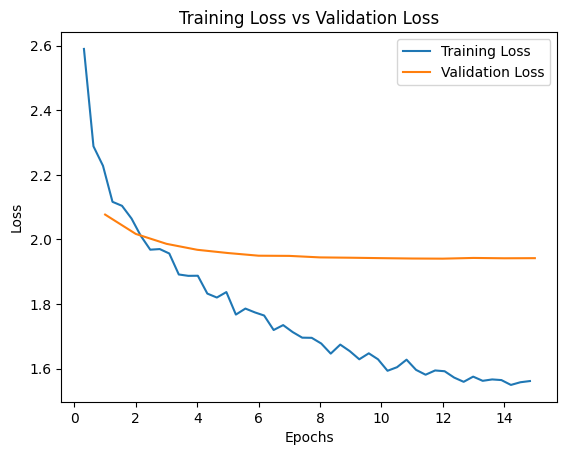

In [23]:
plt.plot(epoch_loss_list, loss_list, label="Training Loss")


plt.plot(eval_epoch_list, eval_loss_list, label="Validation Loss")


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

The plot shows training loss and validation loss against steps. It is very similar to the plot against epochs

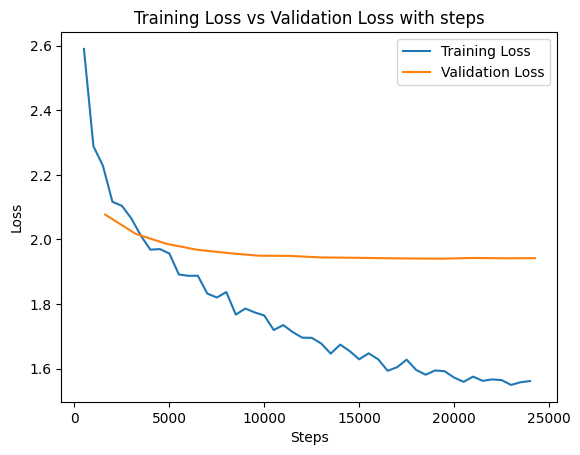

In [24]:
plt.plot(step_list, loss_list, label="Training Loss")


plt.plot(eval_step_list, eval_loss_list, label="Validation Loss")


plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss with steps")
plt.legend()
plt.show()

The plot shows Bleu score vs epochs. We can see that this model achieved a bleu score high of approximately 18.29. When testing the original pretrained model against the dataset, we obtained the sacreBLEU score of 9.948, which means that we have increased our score by around 8.

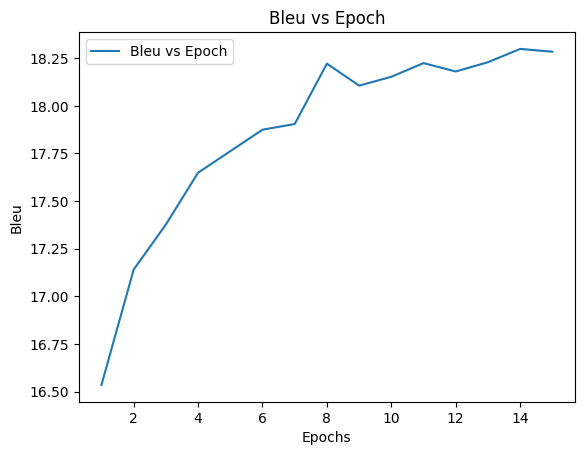

In [25]:
plt.plot(eval_epoch_list, eval_bleu_list, label="Bleu vs Epoch")


plt.xlabel("Epochs")
plt.ylabel("Bleu")
plt.title("Bleu vs Epoch")
plt.legend()
plt.show()

## Testing

We get the path of the best model saved.

In [26]:
best_ckpt_path = trainer.state.best_model_checkpoint

In [27]:
print(best_ckpt_path)

finetuned_marian-lr1e-6_16bat/checkpoint-19404


We then load theat model for testing.

In [9]:
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("finetuned_marian-lr1e-6_16bat/checkpoint-19404")


We use the trainer to run through the test dataset. We only set eval_dataset so that it does not do training.

In [ ]:
# arguments for Trainer
test_args = Seq2SeqTrainingArguments(
    output_dir="testing",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=15,
    save_strategy = "epoch",
    num_train_epochs=15,
    predict_with_generate=True,
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=test_args,
    eval_dataset=tokenized_books["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

test_results = trainer.evaluate(tokenized_books["test"])


The test results is within expectation achieved an eval_bleu score of 18.20.

In [55]:
test_results

{'eval_loss': 1.9230282306671143,
 'eval_bleu': 18.2028,
 'eval_gen_len': 34.3472,
 'eval_runtime': 712.496,
 'eval_samples_per_second': 4.539,
 'eval_steps_per_second': 0.285}

### Different learning rate and batch size results

The model below uses learning rate of 1e-4, we observed relatively unstable BLEU scores and a high validation loss rate, which increased towards the end of training. These signs suggest that the model may have overshot the optimal solution, leading to a worsening performance, indicating that the learning rate was too high. Additionally, these models exhibited a notable gap between training and validation losses, which could imply overfitting.  

Green is for batch 16 and learning rate of 1e-4.
Orange is for batch 8 and learning rate of 1e-4.

<div><img src= "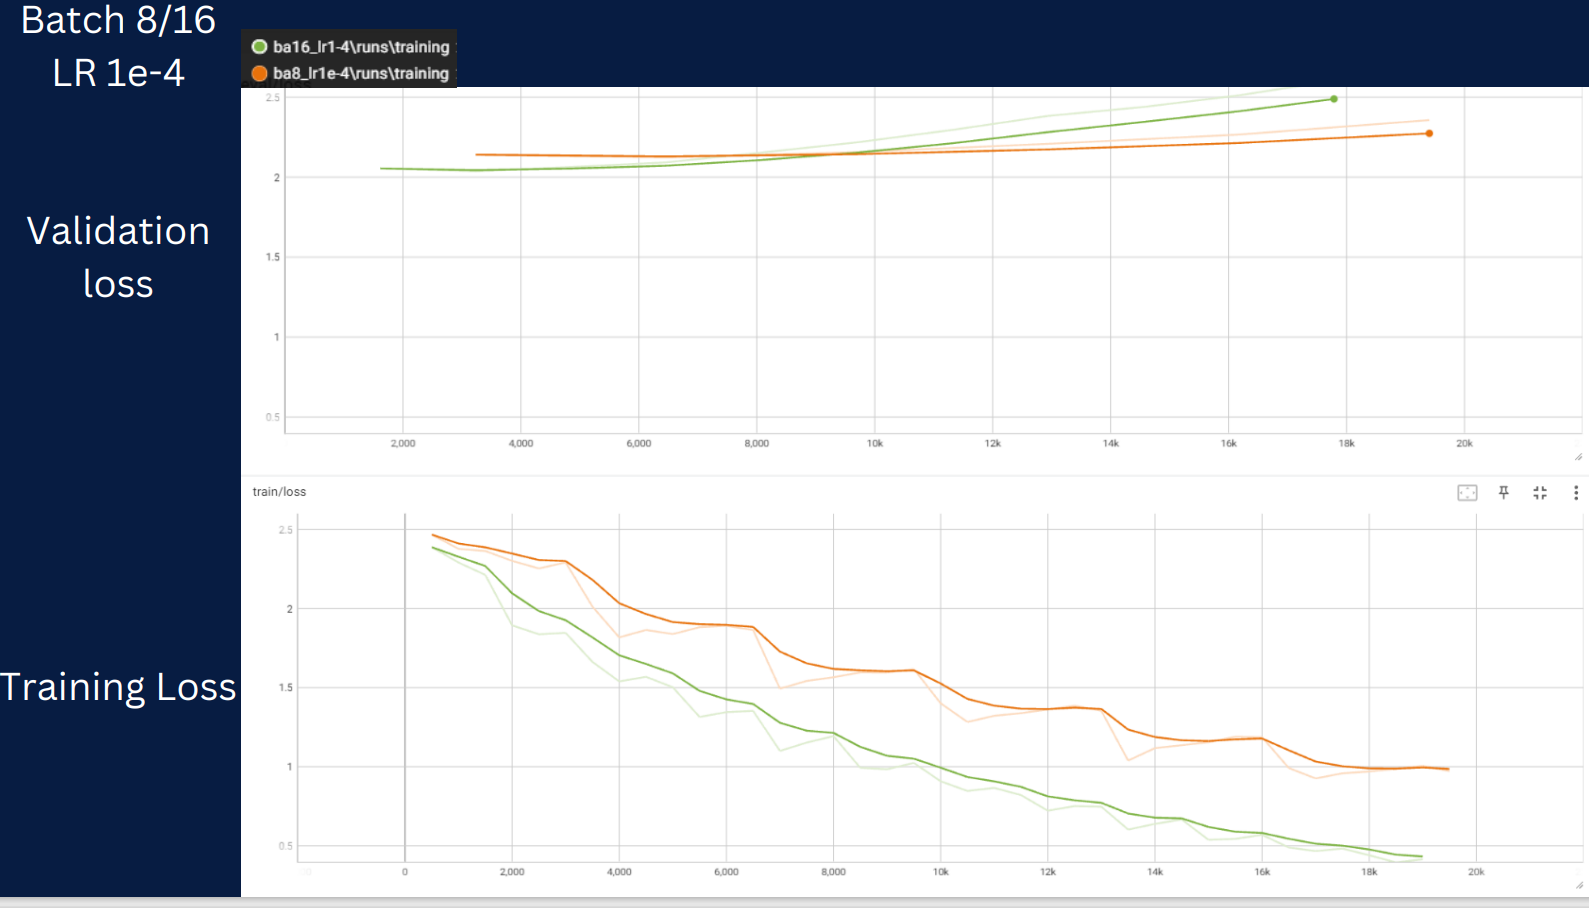
" /img></div>

The model "ba16 lr1e-5" achieved the lowest validation loss, but the higher validation loss rate compared to the testing loss rate might indicate underfitting. However, this model resulted in the best sacreBLEU score of 17.88, a significant improvement compared to other models. We also used these parameters in the notebook where we achieved a high sacreBleu score of 18.29.

<div><img src= "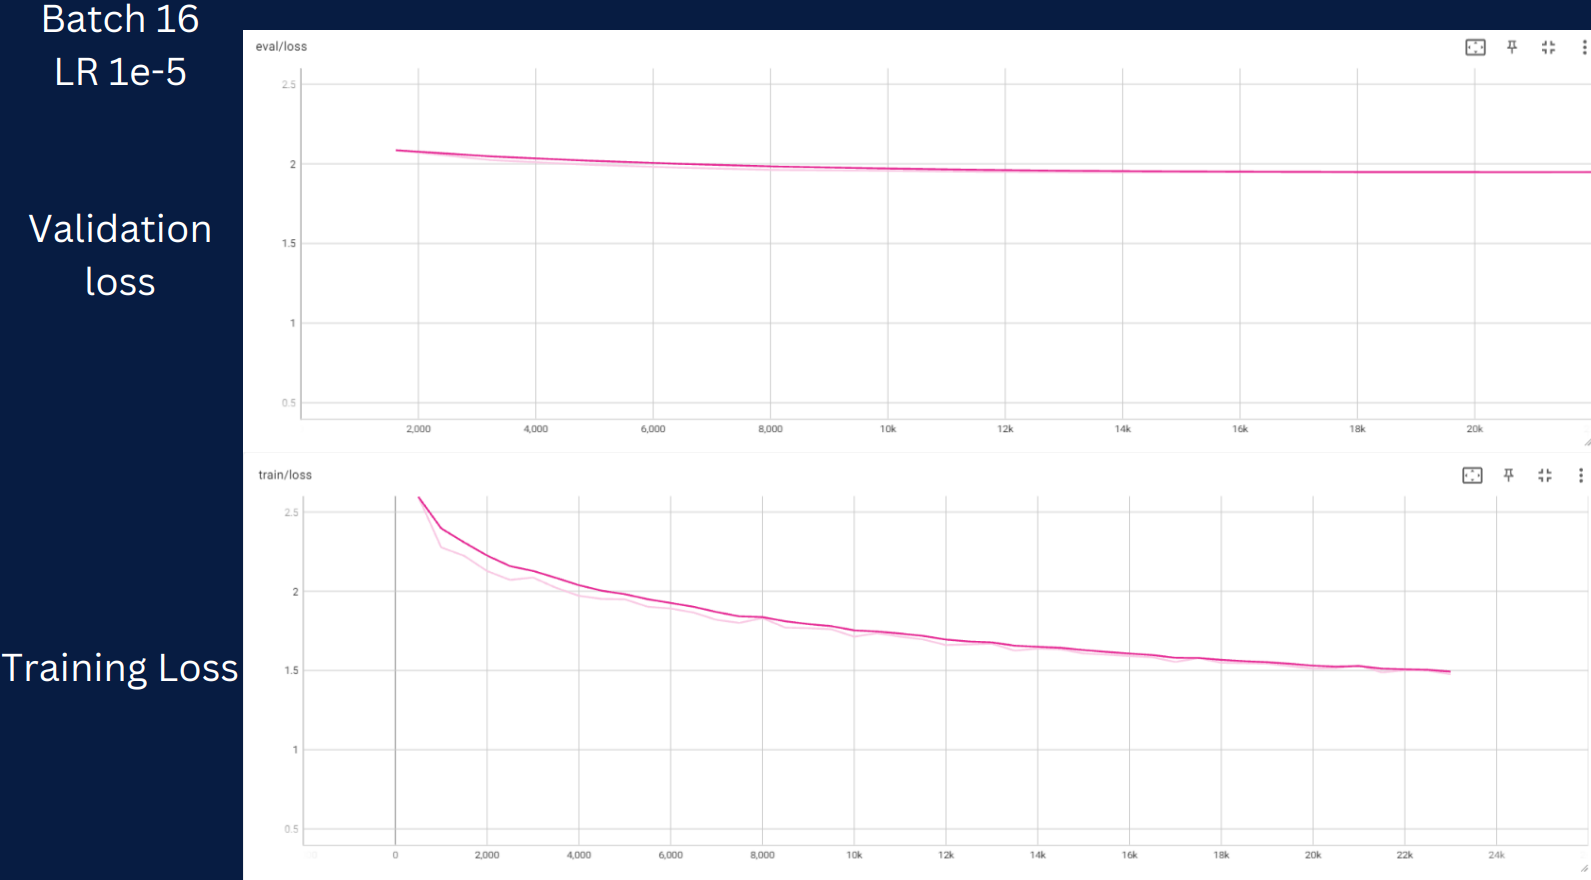
"/img> </div>

On the other hand, the "ba8 lr2e-6" model showed similar loss rates between validation and training, indicating a good fit. Nonetheless, this model's higher validation loss rate suggested poorer performance on the test set, due to the model not learning fast enough to understand the translations. 

<div> <img src= "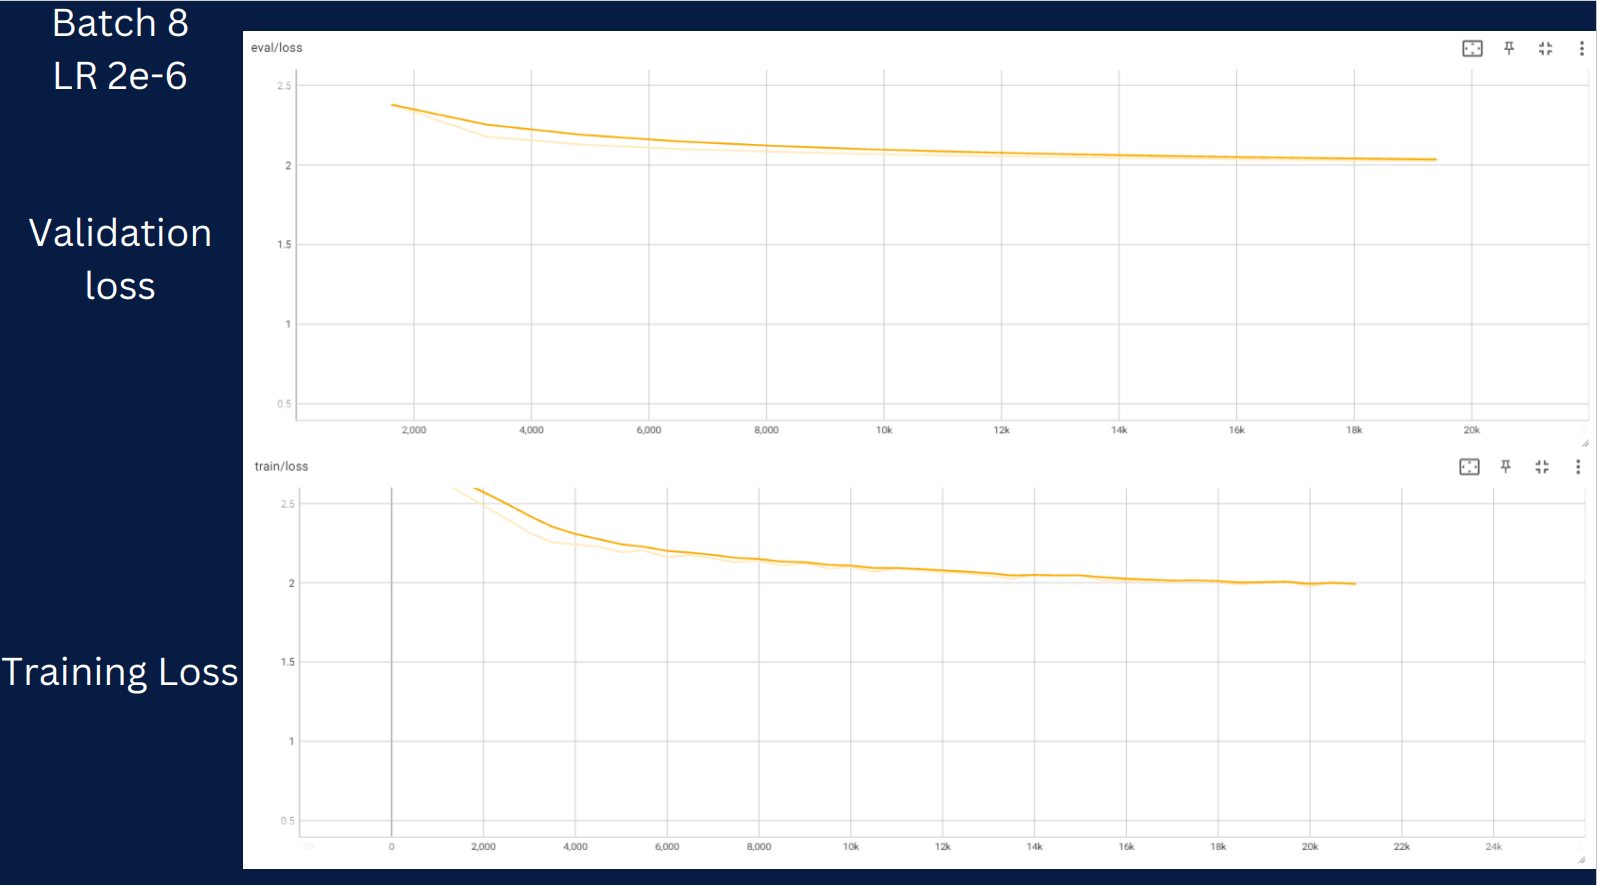
" /img> </div>

As we can see, the batch size of 8 and learning rate of 1e-4 and 2e-6 achieved their highest bleu score less than 16.5. The batch size of 16 and learning of 1e-4 achieved their highest learning rate of 17. The batch size of 16 and learning rate 1e-5 achieved the highest bleu score of 17.88. Notably when running this pair again in this notebook, we achieved a bleu score high of 18.29. Thus, we have shown that best batch size is 16 and best learning rate is 1e-5

<div><img src= "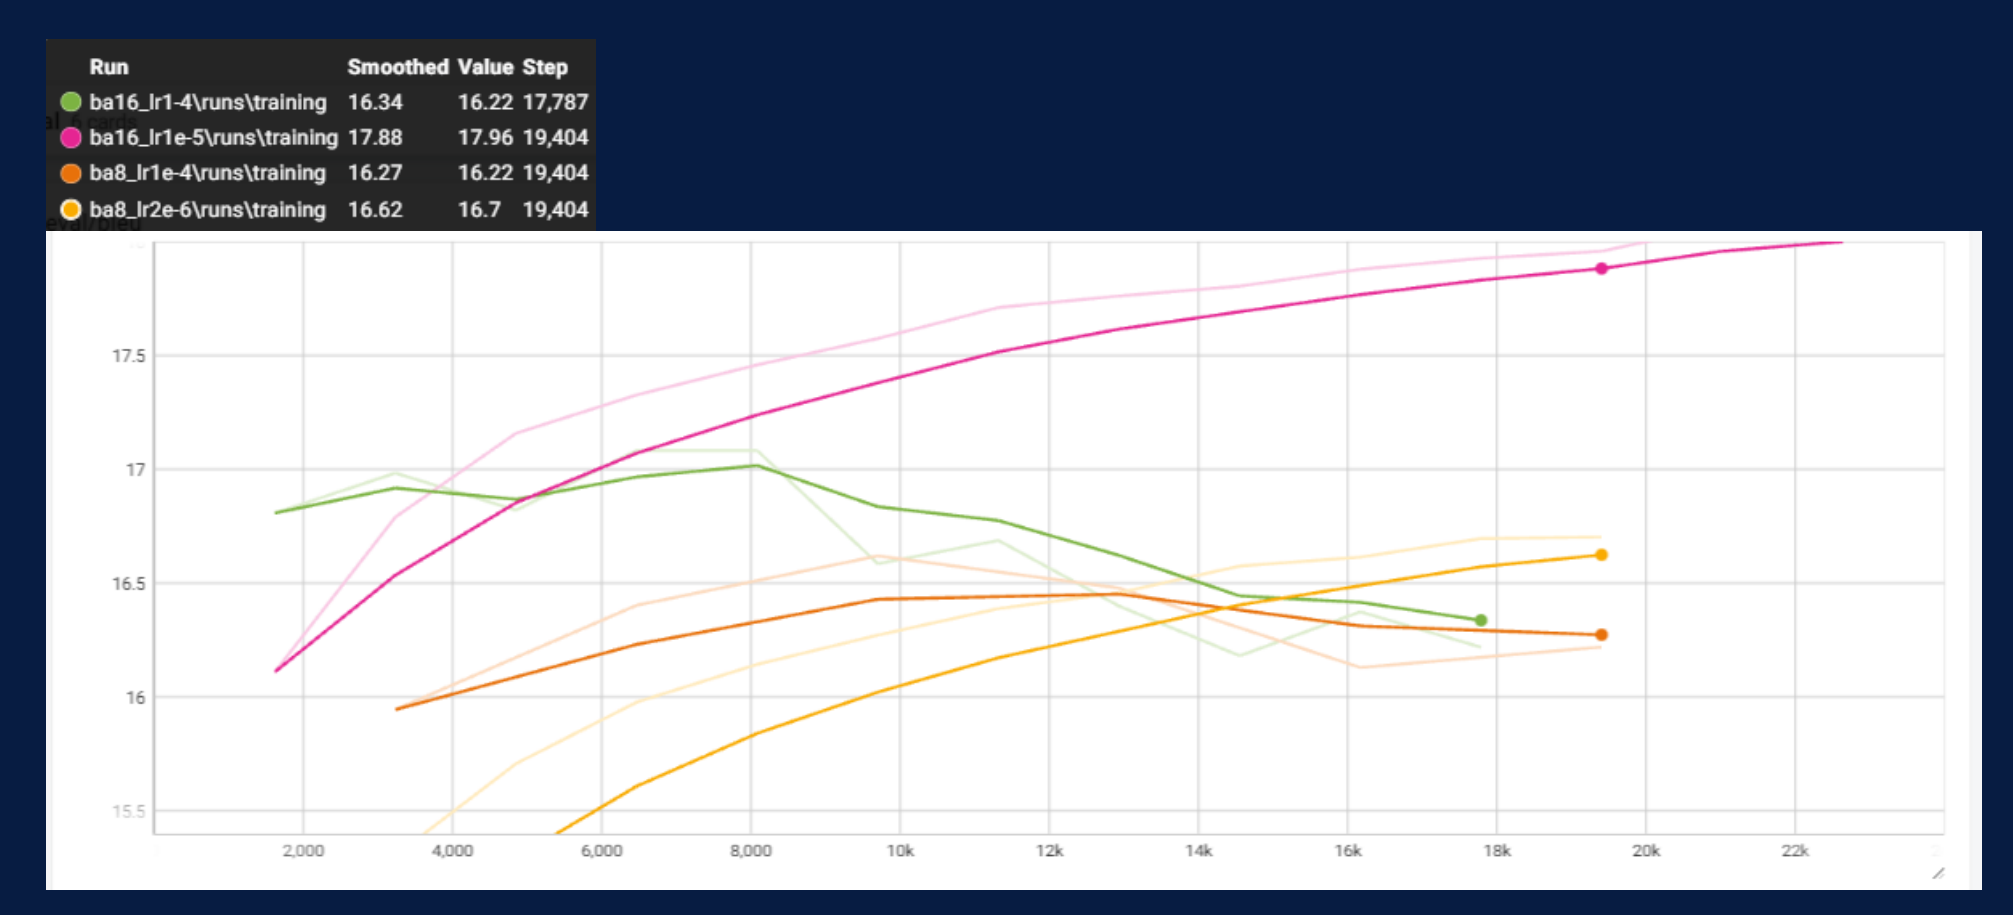
" /img></div>

In conclusion, adjusting the learning rates in the models led to varied outcomes, with the "ba16 lr1e-5" model showing promising results in terms of sacreBLEU score, despite concerns of potential underfitting. The "ba8 lr2e-6" model demonstrated a balanced fit but with slightly inferior performance on the test set. These findings highlight the importance of finding an optimal learning rate that strikes the right balance between learning effectiveness and generalization capabilities in translation tasks. 

## Inference

Here we used the fine tuned model and test out its translation capabilities.

In [77]:
from transformers import pipeline
translator = pipeline("translation", model=fine_tuned_model, tokenizer=tokenizer, device=0)
translator("Four hands grabbed me and I was dragged up the stairs.")

[{'translation_text': 'Quattro mani mi afferrarono e fui trascinato su per la scala.'}]

We also loaded the pre-trained model and tested out its translation capabilities for comparison.

In [62]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [78]:
translator = pipeline("translation", model=model, tokenizer=tokenizer, device=0)
translator("Four hands grabbed me and I was dragged up the stairs.")

[{'translation_text': 'Quattro mani mi hanno afferrato e sono stato trascinato su per le scale.'}]

The expected translation is : Quattro mani mi afferrarono e io fui trascinata su per le scale..
As we can see, the fine tuned model produces a better translation of the sentence.

## Conclusion


From huggingface, 54 models used this dataset. Most of the models have the BLEU score ranging from 5 to 21, while the highest BLEU score was a model that translates from english to portuguese, with a BLEU score of 44, using a big transformer model. 

https://huggingface.co/rossanez/opus-mt-finetuned-en-es


https://huggingface.co/ethansimrm/test_t5_small_example_kaggle2 


https://huggingface.co/Carlosino/my_awesome_opus_books_model

For english to italian in particular, there is only one other model, which did not have a BLEU score, but it did have a validation loss of 2.8. 
https://huggingface.co/mriggs/mt5-small-finetuned-8epochs-opus_books-en-to-it



The highest BLEU score was a model that translates from english to portuguese, with a BLEU score of 44, using a big transformer model.
https://huggingface.co/arcadinis/opus-mt-tc-big-en-pt-finetuned-en-to-pt

We can see by fine tuning our model, we have improved the accuracy of english to Italian translations. However, the bleu score we aimed to achieved was 30 to produce good translations. Therefore, many imrpovements can be made. Improvements that can be made are using a bigger dataset and using a bigger pre-trained transformer model. Expanding the dataset could potentially lead to substantial performance gains, as translation models heavily rely on the volume and diversity of training data. Given more time and resources, incorporating a larger dataset could be a promising avenue for enhancing the model’s accuracy and fluency. Using a bigger transformer model as a pretrained model might have yielded better results due to having more parameters.

 However, due to hardware and time constraints, we were unable to adopt such a model or dataset in the current project. In future endeavors, investing in more powerful hardware and allocating time for training with larger transformer models could offer significant performance improvements. 